### **Part 1:**

Implement the MCMC sampling approach for a MIMO transceiver with
N t = N r = 2 and N t = N r = 8 and 16-QAM. 


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import mlcomm_project as mlcomm
import random

M = 16 # 16-QAM 

"""
Returns hermitian of a matrix
"""
def hermitian(A):
    return np.transpose(A).conj()
  
"""
Noise is zero-mean, multivariate, circularly-symmetric Gaussian with a scaled 
identity as covariance.
"""
def get_noise(Nr, sigma2n):
  noise_mean = np.zeros((Nr,)) # 0 mean noise variance
  noise_covariance = np.eye(Nr) * sigma2n
  noise = np.random.randn(Nr,1) + 1j * np.random.randn(Nr,1)
  return noise


"""
Channel model H if flat-fading and the entries of H are iid. 
circularly-symmetric Gaussian with zero mean and unit variance 
"""
def get_H(Nt, Nr):
  H = np.random.randn(Nr,Nt) + 1j * np.random.randn(Nr,Nt)
  return H


Mc = 4 # M = 2^Mc i.e. for 16-QAM: 16 = 2^Mc i.e. Mc = 4 i.e. 4 bits per symbol


"""
16-QAM constellation Signal & labels 
"""
sig_16_qam = mlcomm.qam_cstll(M)
labels_16_qam = mlcomm.qam_labels(M)


def return_idx(A, b):
    return np.where((A==b[:,None]).all(-1))[1]
  
  
I = 10 # 10 Iterative sampling steps.

"""
Get input & output for a MIMO defined by Nt transmitters & Nr Receivers 
operating in a 16-QAM regime where channel matrix H is known to both
transmitter & receiver and for given noise

Params:
      b_sub_arr: bit sequence for which corresponding input/output are required
      Nt: No. of transmitters
      Nr: No. of receivers
      sigma2n: variance of noise 
"""
def get_in_out(b_sub_arr, Nt, Nr, sigma2n):
  x_idx = 0
  H = get_H(Nt, Nr)
  noise = get_noise(Nr, sigma2n)
  X = np.zeros((Nt,1), dtype=complex)
  for b_sub in b_sub_arr:
    temp = b_sub.reshape((1, len(b_sub_arr[0])))
    idx = return_idx(labels_16_qam, temp)
    X[x_idx] = sig_16_qam[idx]
    x_idx += 1
  Y = H.dot(X) + noise
  return  Y,  X

small_delta = 10e-13 # To prevent divide by 0 errors


"""
Will contain exact LLRs for equally likely constellation symbols for the set
where ith bit position is either 0 or 1
"""
exact_llr_n_2 = np.zeros((I, 2 * Mc), dtype=np.float128)     


"""
Bitwise Gibbs sampler
"""
def bitwise_gibbs_sampler(Nt, Nr, sigma2n):
  K = Nt * Mc
  b = np.random.randint(2, size=(K)) # Initiliase initial bit vector randomly
  split_val = K / 4 # for a 16 QAM regime, labels are of  bits
  B = np.zeros((I, K), dtype=int)
  L = np.zeros((I, K), dtype=np.float128)
  H = get_H(Nt, Nr)
  for n in range(1, I+1):
    for i in range(1, K+1):
      b_1 = np.copy(b)
      b_1[i-1] = 1
      b_0 = np.copy(b)
      b_0[i-1] = 0
      b_sub_arr_1 = np.array_split(b_1, split_val)
      b_sub_arr_0 = np.array_split(b_0, split_val)
      y_plus, d_plus = get_in_out(b_sub_arr_1, Nt, Nr, sigma2n)
      y_minus, d_minus = get_in_out(b_sub_arr_0, Nt, Nr, sigma2n)
      if Nt == 2:
        Nur = np.e ** (-1 * np.absolute((np.transpose(y_minus - H.dot(d_minus)).dot(y_minus - H.dot(d_minus)))) / (2 * sigma2n))
        Der = np.e ** (-1 * np.absolute((np.transpose(y_plus - H.dot(d_plus)).dot(y_plus - H.dot(d_plus)))) / (2 * sigma2n))
        if Der[0][0] == 0:
          Der[0][0] = small_delta
        exact_llr_n_2[n-1][i-1] += np.log2(Nur[0][0]/Der[0][0])
      gamma_i = (np.linalg.norm(y_minus - H.dot(d_minus)) ** 2) - (np.linalg.norm(y_plus - H.dot(d_plus)) ** 2)
      L[n-1][i-1] = gamma_i
      metric = 1 / (1 + np.e ** (-1 * gamma_i))
      U = random.uniform(0,1)
      if U < metric:
        b[i-1] = 1
      else: 
        b[i-1] = 0
    B[n-1] = b
  return B, L, exact_llr_n_2

### **Part 2:**

Calculate the BICM capacity for the above scenarios for the signal-to-noise ratio (SNR) regime of 0 dB to 15 dB for:



1.   Nt = Nr = 2
2.   Nt = Nr = 8



In [0]:
SNR = [10 ** (SNRdb/10) for SNRdb in range(0, 16)] # corresponding SNRs for 0-15 dB SNRdBs
sigma2_n = [1/snr for snr in SNR] # Noise variance corresponding to SNR

idx = 0

"""Vectors to keep exact and achivable rates for MIMO"""
exact_rates_2 = np.zeros((len(sigma2_n), 1))
achivable_rates_2 = np.zeros((len(sigma2_n), 1))
achivable_rates_8 = np.zeros((len(sigma2_n), 1))

"""Compute and store achivable & exact rates"""
np.warnings.filterwarnings('ignore')
for sigma2 in sigma2_n:
  B_2, L_2, exact_llr_n_2 = bitwise_gibbs_sampler(2,2, sigma2)
  B_8, L_8, _ = bitwise_gibbs_sampler(8,8, sigma2)
  achivable_rates_2[idx] = mlcomm.bicm_cap_mc(B_2, L_2)
  exact_rates_2[idx] = mlcomm.bicm_cap_mc(B_2, exact_llr_n_2)
  achivable_rates_8[idx] = mlcomm.bicm_cap_mc(B_8, L_8)
  idx += 1 

### **Part 3:**

Plot the achivable rates vs. SNR in dB and compare achivable rates with rates from exact LLRs for Nt = Nr = 2 

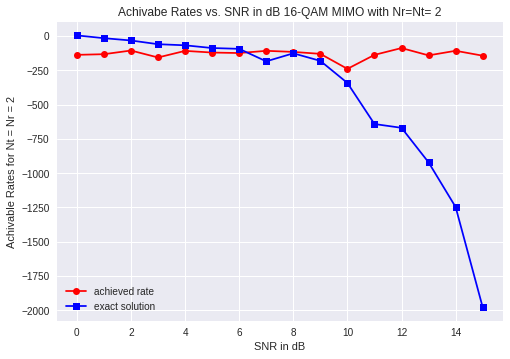

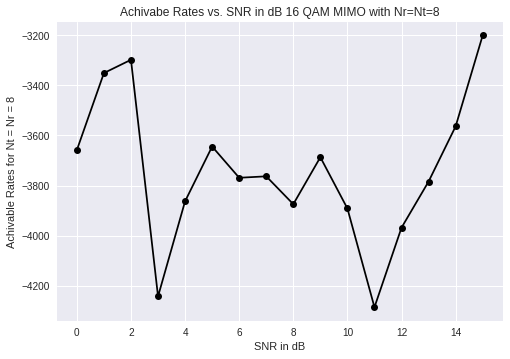

In [263]:
plt.figure(1)
plt.plot(range(0,16), achivable_rates_2, marker='o', color='r', label='achieved rate')
plt.plot(range(0,16), exact_rates_2, marker='s', color='b', label='exact solution')
plt.legend(loc='best')
plt.xlabel('SNR in dB')
plt.ylabel('Achivable Rates for Nt = Nr = 2')
plt.title('Achivabe Rates vs. SNR in dB 16-QAM MIMO with Nr=Nt= 2')

plt.figure(2)
plt.plot(range(0,16), achivable_rates_8, marker='o', color='k')
plt.xlabel('SNR in dB')
plt.ylabel('Achivable Rates for Nt = Nr = 8')
plt.title('Achivabe Rates vs. SNR in dB 16 QAM MIMO with Nr=Nt=8')


plt.show()